In [ ]:
from matplotlib import pyplot as plt
import tensorflow as tf

import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.models import Sequential
from tensorflow.keras import losses

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from tqdm.notebook import tqdm
import numpy as np
import os

In [ ]:
latent_dim = 64
noise_sigma = 0.35
train_AE = True
sml_train_size = 50

In [ ]:
# load train and test images, and pad & reshape them to (-1,32,32,1)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)).astype('float32') / 255.0
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)).astype('float32') / 255.0
x_train = np.pad(x_train, ((0,0),(2, 2), (2, 2),(0,0)))
x_test = np.pad(x_test, ((0,0),(2, 2), (2, 2),(0,0)))
print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes=10, dtype='float32')
y_test = keras.utils.to_categorical(y_test, num_classes=10, dtype='float32')

(60000, 32, 32, 1)
(10000, 32, 32, 1)


# AE

Epoch 1/15
469/469 [==============================] - 6s 6ms/step - loss: 0.3028 - val_loss: 0.1127
Epoch 2/15
469/469 [==============================] - 2s 5ms/step - loss: 0.1050 - val_loss: 0.0805
Epoch 3/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0840 - val_loss: 0.0737
Epoch 4/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0778 - val_loss: 0.0687
Epoch 5/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0743 - val_loss: 0.0666
Epoch 6/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0724 - val_loss: 0.0650
Epoch 7/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0707 - val_loss: 0.0640
Epoch 8/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0696 - val_loss: 0.0633
Epoch 9/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0686 - val_loss: 0.0620
Epoch 10/15
469/469 [==============================] - 2s 5ms/step - loss: 0.0678 - val_loss: 0.0620

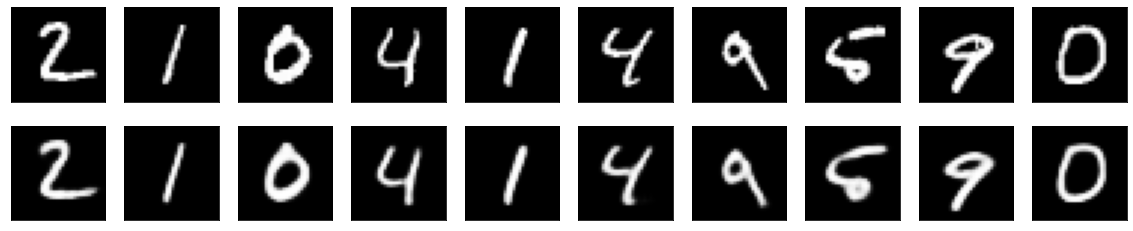

In [ ]:
encoder = Sequential()
encoder.add(layers.Conv2D(16, (4, 4), strides=(2,2), activation='relu', padding='same', input_shape=(32,32,1)))
encoder.add(layers.Conv2D(32, (3, 3), strides=(2,2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(64, (3, 3), strides=(2,2), activation='relu', padding='same'))
encoder.add(layers.Conv2D(96, (3, 3), strides=(2,2), activation='relu', padding='same'))
encoder.add(layers.Reshape((2*2*96,)))
encoder.add(layers.Dense(latent_dim))

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
decoder = Sequential()
decoder.add(layers.Dense(2*2*96,activation='relu', input_shape=(latent_dim,)))
decoder.add(layers.Reshape((2,2,96)))
decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=(2,2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(16, (4, 4), strides=(2,2), activation='relu', padding='same'))
decoder.add(layers.Conv2DTranspose(1, (4, 4), strides=(2,2), activation='sigmoid', padding='same'))

autoencoder = keras.Model(encoder.inputs, decoder(encoder.outputs))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

checkpoint_path = "model_save/cp.ckpt"

if train_AE:
	checkpoint_dir = os.path.dirname(checkpoint_path)
	cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
	                                                 save_weights_only=True)
	autoencoder.fit(x_train + noise_sigma * np.random.randn(*x_train.shape), x_train,
	                epochs=15,
	                batch_size=128,
	                shuffle=True,
	                validation_data=(x_test, x_test),
	                callbacks=[cp_callback])
else:
	autoencoder.load_weights(checkpoint_path)

decoded_imgs = autoencoder.predict(x_test)
latent_codes = encoder.predict(x_test)
decoded_imgs = decoder.predict(latent_codes)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
def plot_metrics(history, metrics=["loss", "accuracy"]):
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])

        plt.legend()
    return plt.show()

In [ ]:
def train_sml(MLP_classifier):
    
    with tf.device('/device:GPU:0'):
        # Pre trained
        train_codes = encoder.predict(x_train[:sml_train_size])
        test_codes = encoder.predict(x_test)

        classifier.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

        history_transfer = classifier.fit(train_codes, y_train[:sml_train_size],
                          epochs=200,
                          batch_size=16,
                          shuffle=True,
                          validation_data=(test_codes, y_test))
        print("\n"*5)
        print("-"*20)
        print("Pre-Trained evaluation:")
        plot_metrics(history_transfer)
        print(classifier.evaluate(test_codes, y_test))
        
        print("-"*20)
        print("\n"*5)


        # Regular
        full_cls_enc = keras.models.clone_model(encoder) # creating new layers (and weights)
        full_cls_cls = keras.models.clone_model(classifier)
        full_cls = keras.Model(full_cls_enc.inputs,full_cls_cls(full_cls_enc.outputs))

        full_cls.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

        history_full = full_cls.fit(x_train[:sml_train_size], y_train[:sml_train_size],
                          epochs=100,
                          batch_size=16,
                          shuffle=True,
                          validation_data=(x_test, y_test))

        print("\n"*5)
        print("-"*20)
        print("Regular Model evaluation:")
        plot_metrics(history_full)
        print(full_cls.evaluate(x_test, y_test))
        print("-"*20)
        print("\n"*5)
        return history_transfer, history_full

## Baseline MLP - FC (10, sigmoid)

In [ ]:
classifier = Sequential()
classifier.add(layers.Dense(10,activation='softmax', input_shape=(latent_dim,)))
train_sml(classifier)

##results with 3 layers : layer1 = 16 + relu, layer2 = 16+relu, layer3= 10+softmax

In [ ]:
classifier = Sequential()

classifier.add(layers.Dense(32, activation='relu', input_shape=(latent_dim,)))
classifier.add(layers.Dense(16, activation='relu'))
classifier.add(layers.Dense(10, activation='softmax'))

train_sml(classifier)

##results with 4 layers:

1.   latent dim+relu
2.   32+relu
3. 16+relu
4. 10+ softmax



In [ ]:
classifier = Sequential()

classifier.add(layers.Dense(latent_dim, activation='relu', input_shape=(latent_dim,)))
classifier.add(layers.Dense(32, activation='relu'))
classifier.add(layers.Dense(16, activation='relu'))
classifier.add(layers.Dense(10, activation='softmax'))

train_sml(classifier)

##results with 5 layers:

1.   latent dim+relu
2. 64+relu
3.   32+relu
4. 16+relu
5. 10+ softmax



In [ ]:
classifier = Sequential()

classifier.add(layers.Dense(100, activation='relu', input_shape=(latent_dim,)))
classifier.add(layers.Dropout(0.5))
classifier.add(layers.Dense(64, activation='relu'))
classifier.add(layers.Dense(32, activation='relu'))
classifier.add(layers.Dense(10, activation='softmax'))

train_sml(classifier)

In [ ]:
classifier

# GAN - generating MNIST images

In [ ]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def build_discrimnator():
    discriminator = Sequential()
    discriminator.add(layers.Dense(256, activation='relu',input_shape=(latent_dim,)))
    discriminator.add(layers.Dense(128, activation='relu'))
    discriminator.add(layers.Dense(64, activation='relu'))
    discriminator.add(layers.Dense(1))
    return discriminator

def discriminator_loss(fake_pred, real_pred):
    loss_fake = cross_entropy(tf.zeros_like(fake_pred), fake_pred)
    loss_real = cross_entropy(tf.ones_like(real_pred), real_pred)
    return loss_fake + loss_real


In [ ]:
def build_generator():
    generator = Sequential()
    generator.add(layers.Flatten(input_shape=(32,32,1)))
    generator.add(layers.Dense(256, activation='relu'))
    generator.add(layers.Dense(128, activation='relu'))
    generator.add(layers.Dense(64, activation='relu'))
    generator.add(layers.Dense(latent_dim))
    return generator

def generator_loss(d_g_z):
    # D(G(z)) should be one in the generator perspective.
    return cross_entropy(tf.ones_like(d_g_z), d_g_z)

def get_noise(batch_size):
    return np.random.randn(batch_size, 32,32,1)
    

In [ ]:
def show_generated(generator):
    for _ in range(30):
      z = get_noise(1)
      image = (decoder.predict(generator(z))).reshape(32,32)
      plt.imshow(image)
      plt.show()

## Regular GAN - first optimize D then G

In [ ]:
gen_optimizer = keras.optimizers.Adam()
disc_optimizer = keras.optimizers.Adam()

@tf.function
def train_step_discriminator(discriminator, generator, images_batch):
    # training step for disc and than gen to avoid saturation
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as disc_tape:
            z = get_noise(images_batch.shape[0])
            gz = generator(z)
            d_pred_real = discriminator(encoder(images_batch))
            d_pred_fake = discriminator(gz)

            disc_loss = discriminator_loss(d_pred_fake, d_pred_real)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        
        return disc_loss

@tf.function
def train_step_generator(discriminator, generator, images_batch):
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape:
            z = get_noise(images_batch.shape[0])
            gz = generator(z)
            d_pred_fake = discriminator(gz)

            gen_loss = generator_loss(d_pred_fake)
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

        return gen_loss

In [ ]:
def train_gan_disc_first(batch_size, epochs):
    train_set = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
    discriminator = build_discrimnator()
    generator = build_generator()
    history = {"discriminator_loss": [], "generator_loss": []}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}: ")
        progbar = tf.keras.utils.Progbar(len(train_set))
        disc_loss = []
        gen_loss = []
        
        for n, batch in enumerate(train_set):
            dloss = train_step_discriminator(discriminator, generator, batch)
            disc_loss.append(dloss)
            progbar.update(n+1)
        
        for n, batch in enumerate(train_set):
             gloss = train_step_generator(discriminator, generator, batch)
             gen_loss.append(gloss)
             progbar.update(n+1)
        
        
        epoch_disc_loss = np.array(disc_loss).mean()
        epoch_gen_loss = np.array(gen_loss).mean()
        history["discriminator_loss"].append(epoch_disc_loss)
        history["generator_loss"].append(epoch_gen_loss)
        print(f"disc_loss: {epoch_disc_loss}, gen_loss: {epoch_gen_loss}. ")
      
    plt.plot(np.arange(1, epochs+1), history["discriminator_loss"], label="Discriminator_Loss")
    plt.plot(np.arange(1, epochs+1), history["generator_loss"], label="Generator_Loss")
    plt.legend()
    plt.show()
    return history, generator

In [ ]:
disc_first_history, disc_first_generator = train_gan_disc_first(128, 50)

In [ ]:
show_generated(disc_first_generator)

# GAN - avoid saturation - disc step followed by gen step

In [ ]:
gen_optimizer = keras.optimizers.Adam()
disc_optimizer = keras.optimizers.Adam()

@tf.function
def train_step_simoultanous(discriminator, generator, images_batch):
    # training step for disc and than gen to avoid saturation
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
            z = get_noise(images_batch.shape[0])
            gz = generator(z)
            d_pred_real = discriminator(encoder(images_batch))
            d_pred_fake = discriminator(gz)
            
            disc_loss = discriminator_loss(d_pred_fake, d_pred_real)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))


            gen_loss = generator_loss(d_pred_fake)
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        
        return disc_loss, gen_loss

In [ ]:
def train_gan_stepwise(batch_size, epochs):
    train_set = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
    discriminator = build_discrimnator()
    generator = build_generator()
    history = {"discriminator_loss": [], "generator_loss": []}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}: ")
        progbar = tf.keras.utils.Progbar(len(train_set))
        disc_loss = []
        gen_loss = []
        
        for n, batch in enumerate(train_set):
            progbar.update(n+1)
            dloss, gloss = train_step_simoultanous(discriminator, generator, batch)
            disc_loss.append(dloss)
            gen_loss.append(gloss)
        
        epoch_disc_loss = np.array(disc_loss).mean()
        epoch_gen_loss = np.array(gen_loss).mean()
        history["discriminator_loss"].append(epoch_disc_loss)
        history["generator_loss"].append(epoch_gen_loss)
        print(f"disc_loss: {epoch_disc_loss}, gen_loss: {epoch_gen_loss}. ")
    
    plt.plot(np.arange(1, epochs+1), history["discriminator_loss"], label="Discriminator_Loss")
    plt.plot(np.arange(1, epochs+1), history["generator_loss"], label="Generator_Loss")
    plt.legend()
    plt.show()
    return history, generator

In [ ]:
stepwise_history, stepwise_generator = train_gan_stepwise(128, 50);

In [ ]:
show_generated(stepwise_generator)

In [ ]:
gen_optimizer = keras.optimizers.Adam()
disc_optimizer = keras.optimizers.Adam()

def train_gan_combined(batch_size, epochs):
    train_set = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
    discriminator = build_discrimnator()
    generator = build_generator()
    history = {"discriminator_loss": [], "generator_loss": []}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}: ")
        progbar = tf.keras.utils.Progbar(len(train_set))
        disc_loss = []
        gen_loss = []
        
        if epoch < 50: # stepwise (or simultanously)
            for n, batch in enumerate(train_set):
              progbar.update(n+1)
              dloss, gloss = train_step_simoultanous(discriminator, generator, batch)
              disc_loss.append(dloss)
              gen_loss.append(gloss)
        
        else: # optimize D, then optimize G
            for n, batch in enumerate(train_set):
                progbar.update(n+1)
                dloss = train_step_discriminator(discriminator, generator, batch)
                disc_loss.append(dloss)
            
            for n, batch in enumerate(train_set):
                progbar.update(n+1)
                gloss = train_step_generator(discriminator, generator, batch)
                gen_loss.append(gloss)

        epoch_disc_loss = np.array(disc_loss).mean()
        epoch_gen_loss = np.array(gen_loss).mean()
        history["discriminator_loss"].append(epoch_disc_loss)
        history["generator_loss"].append(epoch_gen_loss)
        print(f"disc_loss: {epoch_disc_loss}, gen_loss: {epoch_gen_loss}. ")
    
    plt.plot(np.arange(1, epochs+1), history["discriminator_loss"], label="Discriminator_Loss")
    plt.plot(np.arange(1, epochs+1), history["generator_loss"], label="Generator_Loss")
    plt.legend()
    plt.show()
    return history, generator

In [ ]:
combined_history, combined_generator = train_gan_combined(128, 200)

In [ ]:
show_generated(combined_generator)

In [ ]:
for _ in range(10):
    im_l1, im_l2 = encoder(x_test[5:6]), encoder(x_test[9:10])
    z1, z2 = get_noise(1), get_noise(1)
    z_l1, z_l2 = combined_generator(z1), combined_generator(z2)

    AE = []
    gen = []
    for alpha in np.arange(0., 1.1, 0.1):
        # AE latent space
        real_interpolation = decoder.predict((alpha*im_l1) + ((1-alpha)*im_l2))
        AE.append(real_interpolation)
        # generator latent space
        fake_interpolation = decoder.predict((alpha*z_l1) + ((1-alpha)*z_l2))
        gen.append(fake_interpolation)


    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(1, n + 1):
        # Display original
        ax = plt.subplot(2, n, i)
        plt.imshow(AE[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        plt.imshow(gen[i].reshape(32, 32))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Digit Mapper - conditional GAN

In [ ]:
def cond_gen():
    noise_input = layers.Input(shape= (32,))
    digit_oh = layers.Input(shape=(10,))
    concat = layers.Concatenate()([digit_oh, noise_input])
    x = layers.Dense(512, 'relu')(concat)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(256, 'relu')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(128, 'relu')(x)
    x = layers.BatchNormalization()(x)
    out = layers.Dense(latent_dim)(x)
    return keras.Model([digit_oh, noise_input], out)

def cond_disc():
    latent_input = layers.Input(shape=(latent_dim,))
    digit_oh = layers.Input(shape=(10,))
    concat = layers.Concatenate()([digit_oh, latent_input])
    x = layers.Dense(256)(concat)
    x = layers.LeakyReLU(0.2)(x)
    
    x = layers.Dense(128)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    out = layers.Dense(1)(x)
    return keras.Model([digit_oh, latent_input], out)

In [ ]:
gen_optimizer = keras.optimizers.Adam()
disc_optimizer = keras.optimizers.Adam()

encoder.trainable = False


def get_noise(batch_size):
    return np.random.randn(batch_size, 32)

@tf.function
def train_step_discriminator(discriminator, generator, images_batch, labels_batch):
    # training step for disc and than gen to avoid saturation
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as disc_tape:
            z = get_noise(images_batch.shape[0])
            gz = generator([labels_batch, z])
            d_pred_real = discriminator([labels_batch, encoder(images_batch)])
            d_pred_fake = discriminator([labels_batch, gz])

            disc_loss = discriminator_loss(d_pred_fake, d_pred_real)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        
        return disc_loss

@tf.function
def train_step_generator(discriminator, generator, images_batch, labels_batch):
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape:
            z = get_noise(images_batch.shape[0])
            
            gz = generator([labels_batch, z])
            d_pred_fake = discriminator([labels_batch, gz])
            
            gen_loss = generator_loss(d_pred_fake)
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

        return gen_loss

        
@tf.function
def train_step_simoultanous(discriminator, generator, images_batch, labels_batch):
    # training step for disc and than gen to avoid saturation
    with tf.device('/device:GPU:0'):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
  
            z = get_noise(images_batch.shape[0])
            gz = generator([labels_batch, z])
            d_pred_real = discriminator([labels_batch, encoder(images_batch)])
            d_pred_fake = discriminator([labels_batch, gz])
            

            disc_loss = discriminator_loss(d_pred_fake, d_pred_real)
            disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))


            gen_loss = generator_loss(d_pred_fake)
            gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        
        return disc_loss, gen_loss


def train_gan_combined(batch_size, epochs):
    train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    discriminator = cond_disc()
    generator = cond_gen()
    history = {"discriminator_loss": [], "generator_loss": []}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}: ")
        progbar = tf.keras.utils.Progbar(len(train_set))
        disc_loss = []
        gen_loss = []
        
        if epoch < 50: # stepwise (or simultanously)
            for n, (img_batch, label_batch) in enumerate(train_set):
              progbar.update(n+1)
              dloss, gloss = train_step_simoultanous(discriminator, generator, img_batch, label_batch)
              disc_loss.append(dloss)
              gen_loss.append(gloss)
        
        else: # optimize D, then optimize G
            for n, (img_batch, label_batch) in enumerate(train_set):
                progbar.update(n+1)
                dloss = train_step_discriminator(discriminator, generator, img_batch, label_batch)
                disc_loss.append(dloss)
            
            for n, (img_batch, label_batch) in enumerate(train_set):
                progbar.update(n+1)
                gloss = train_step_generator(discriminator, generator, img_batch, label_batch)
                gen_loss.append(gloss)

        epoch_disc_loss = np.array(disc_loss).mean()
        epoch_gen_loss = np.array(gen_loss).mean()
        history["discriminator_loss"].append(epoch_disc_loss)
        history["generator_loss"].append(epoch_gen_loss)
        print(f"disc_loss: {epoch_disc_loss}, gen_loss: {epoch_gen_loss}. ")
    
    plt.plot(np.arange(1, epochs+1), history["discriminator_loss"], label="Discriminator_Loss")
    plt.plot(np.arange(1, epochs+1), history["generator_loss"], label="Generator_Loss")
    plt.legend()
    plt.show()
    return history, generator  

Epoch 0/100: 
469/469 [==============================] - 3s 6ms/step
disc_loss: 2.3614983558654785, gen_loss: 1.524898648262024. 
Epoch 1/100: 
469/469 [==============================] - 2s 4ms/step
disc_loss: 1.3261057138442993, gen_loss: 0.9857000112533569. 
Epoch 2/100: 
469/469 [==============================] - 2s 4ms/step
disc_loss: 0.9788789749145508, gen_loss: 1.3896172046661377. 
Epoch 3/100: 
469/469 [==============================] - 2s 4ms/step
disc_loss: 2.3511292934417725, gen_loss: 4.034578800201416. 
Epoch 4/100: 
469/469 [==============================] - 2s 4ms/step
disc_loss: 1.0958502292633057, gen_loss: 1.3801370859146118. 
Epoch 5/100: 
469/469 [==============================] - 2s 4ms/step
disc_loss: 0.9513370990753174, gen_loss: 1.4758440256118774. 
Epoch 6/100: 
469/469 [==============================] - 2s 4ms/step
disc_loss: 1.1578083038330078, gen_loss: 1.4803022146224976. 
Epoch 7/100: 
469/469 [==============================] - 2s 4ms/step
disc_loss: 1.181

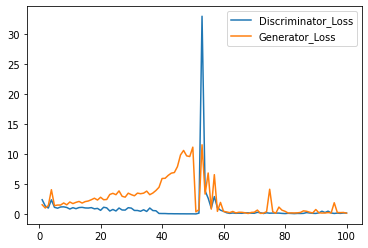

In [ ]:
hist, cond_gan = train_gan_combined(128, 100)

In [ ]:
tf.keras.utils.plot_model(cond_gen(), show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(cond_disc(), show_shapes=True)

In [ ]:
for d in range(10):    
    n = 10
    plt.figure(figsize=(20, 4))
    batch = keras.utils.to_categorical(np.arange(0,10).reshape(-1,1))
    for i in range(1, n + 1):
        # Display reconstruction
        ax = plt.subplot(2, n, i + n)
        im_gen = cond_gan.predict([batch[i-1:i], get_noise(1)])
        # im_gen = cond_gan.predict([batch, get_noise(1)])
        image = decoder.predict(im_gen)
        plt.imshow(image.reshape(32, 32), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title(i-1)
    plt.show()